In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

df = pd.read_csv('C:\\dev\\data\\all_currencies.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.sample(5)

           Symbol      Open      High       Low     Close  Volume  Market Cap
Date                                                                         
2015-11-12    $$$  0.000013  0.000017  0.000013  0.000017   142.0         NaN
2015-11-13    $$$  0.000017  0.000033  0.000016  0.000024    85.0         NaN
2015-11-14    $$$  0.000024  0.000053  0.000023  0.000030   131.0         NaN
2015-11-15    $$$  0.000030  0.000063  0.000022  0.000035   132.0         NaN
2015-11-16    $$$  0.000035  0.000046  0.000032  0.000036   280.0         NaN
...           ...       ...       ...       ...       ...     ...         ...
2018-05-29    ZZC  0.097595  0.101948  0.082738  0.083027   590.0    189967.0
2018-05-30    ZZC  0.083082  0.118589  0.056165  0.082957   263.0    161719.0
2018-05-31    ZZC  0.082941  0.123240  0.082536  0.121377    52.0    161444.0
2018-06-01    ZZC  0.071372  0.102548  0.071372  0.100614    47.0    138924.0
2018-06-02    ZZC  0.100570  0.100657  0.059969  0.089404    63.

Dickey–Fuller test: p=0.943465


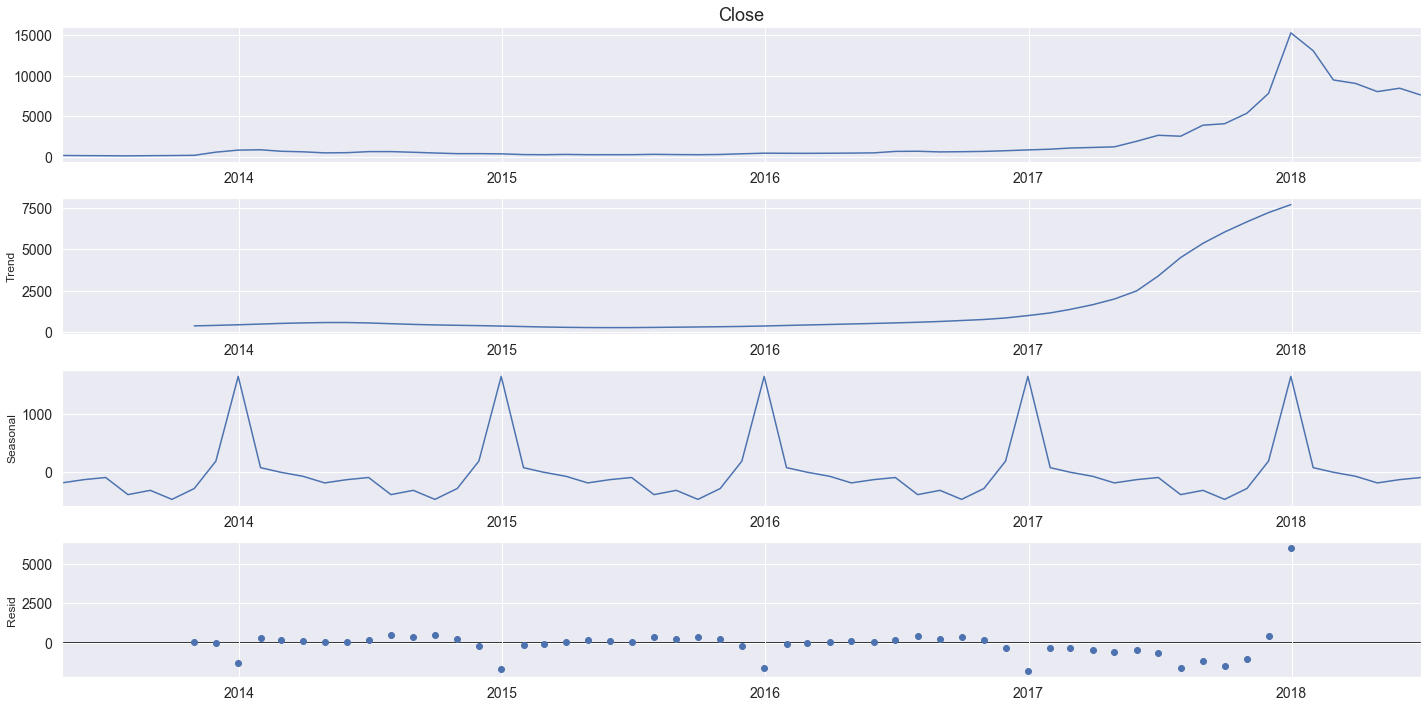

In [3]:
btc=df[df['Symbol']=='BTC']
# Drop some columns
btc.drop(['Volume', 'Market Cap'],axis=1,inplace=True) 

# Lets take just the last year 
#btc = btc.loc['2017']
#btc.shape

btc_month = btc.resample('M').mean()
seasonal_decompose(btc_month.Close, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close)[1])


In [4]:
# Box-Cox Transformations
btc_month['close_box'], lmbda = stats.boxcox(btc_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

Dickey–Fuller test: p=0.509378


Dickey–Fuller test: p=0.155278
Dickey–Fuller test: p=0.012923
Dickey–Fuller test: p=0.081588


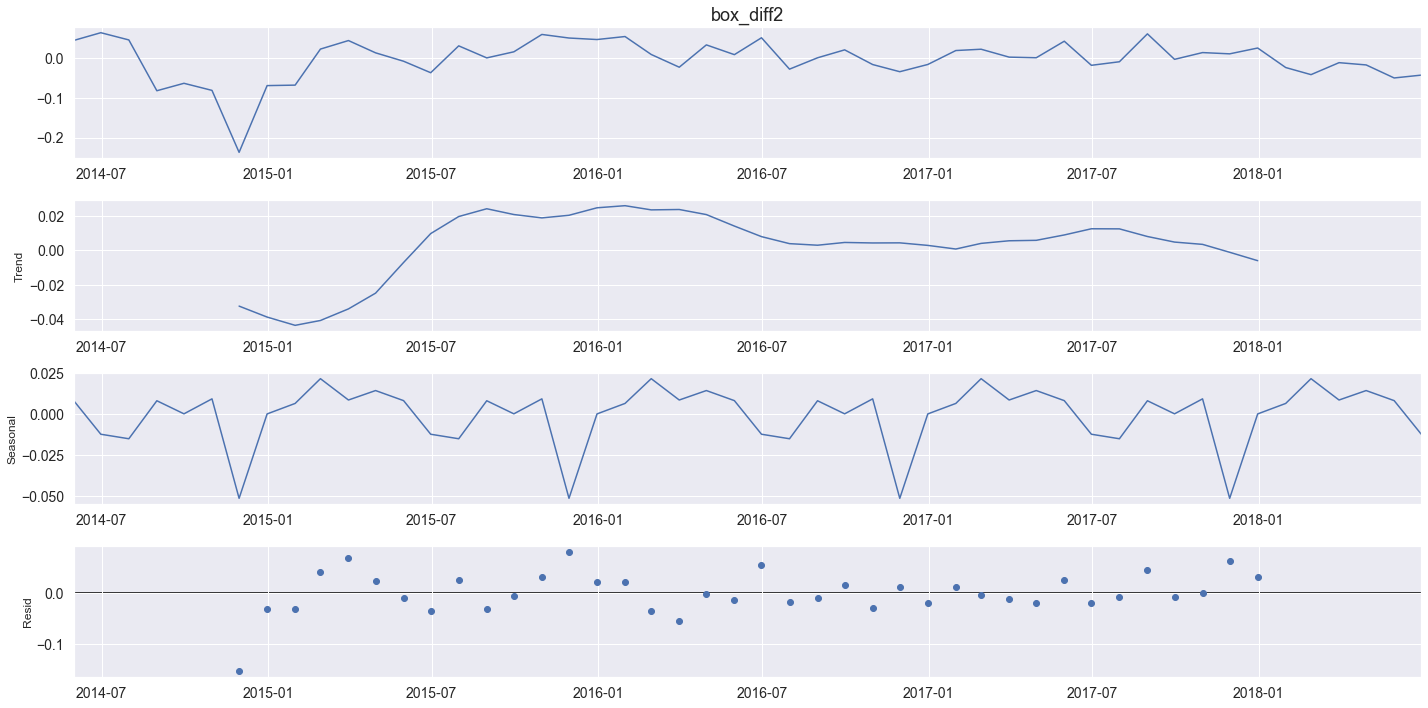

In [6]:
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])


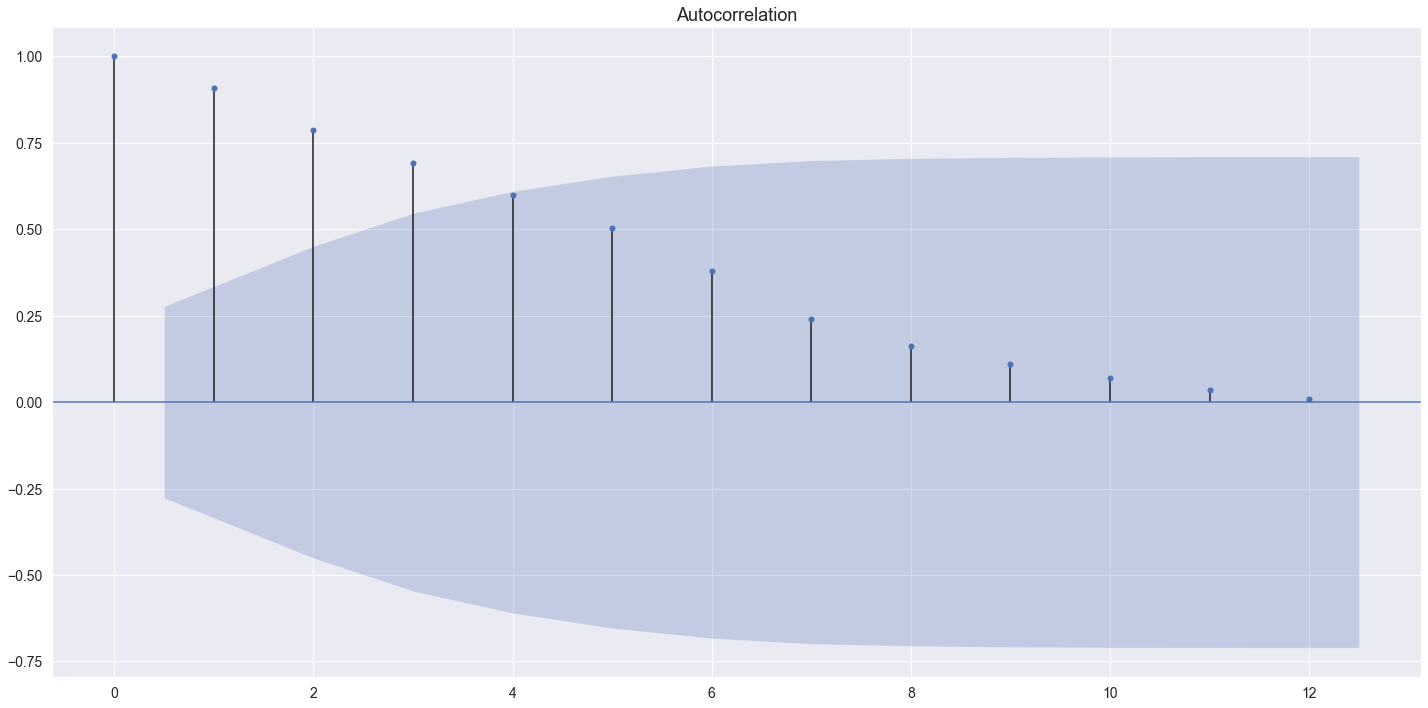

In [9]:
#autocorrelation_plot(btc_month.close)
plot_acf(btc_month.Close[13:].values.squeeze(), lags=12)
plt.tight_layout()

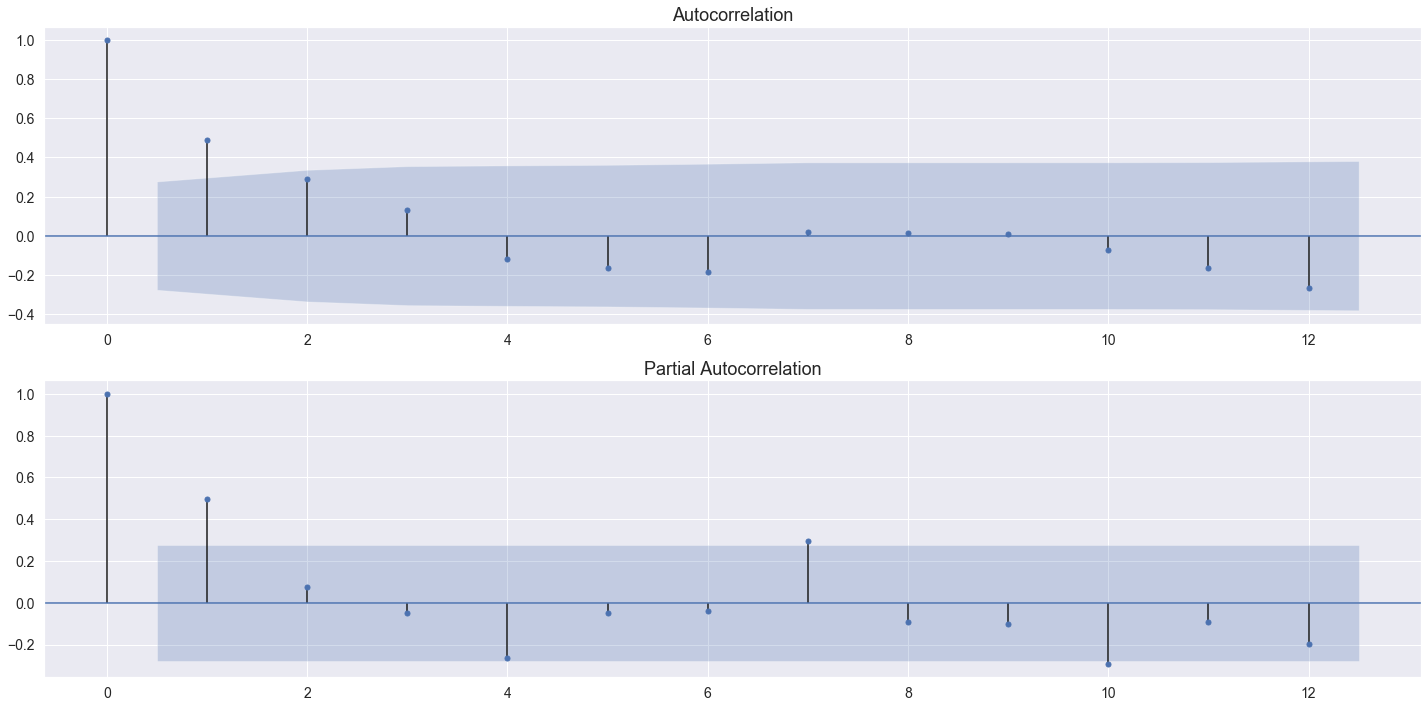

In [10]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()

In [11]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    

In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

  parameters         aic
3     (1, 0) -225.144309
1     (0, 1) -224.700279
4     (1, 1) -223.182407
6     (2, 0) -223.174192
2     (0, 2) -222.933809
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   63
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 114.572
Date:                Sun, 31 Oct 2021   AIC                           -225.144
Time:                        23:11:38   BIC                           -220.890
Sample:                    04-30-2013   HQIC                          -223.474
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3737      0.147      2.548      0.011      

Dickey–Fuller test:: p=0.000000


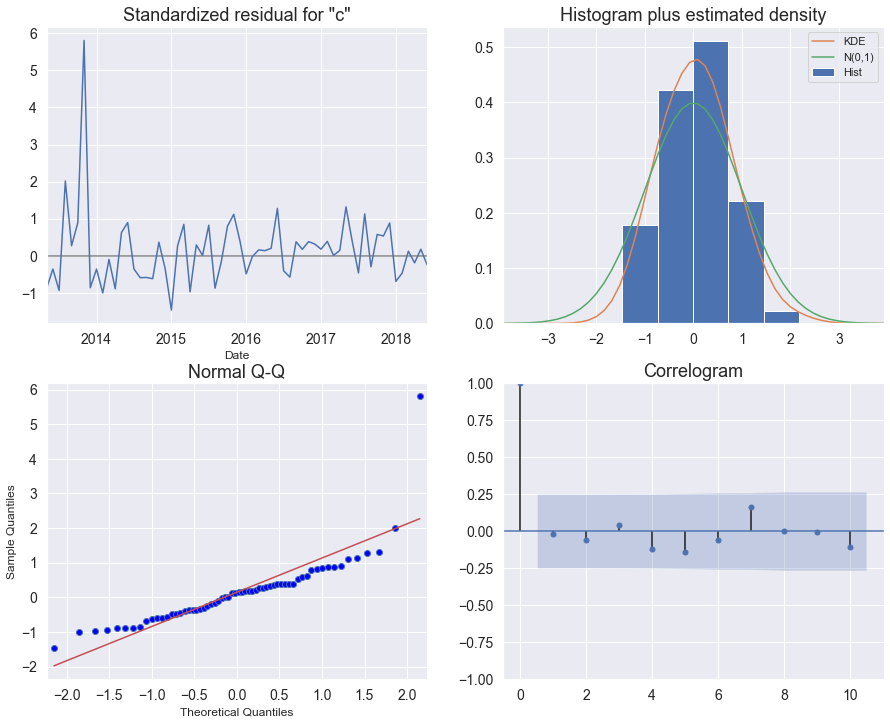

In [14]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [15]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
    

Text(0, 0.5, 'USD')

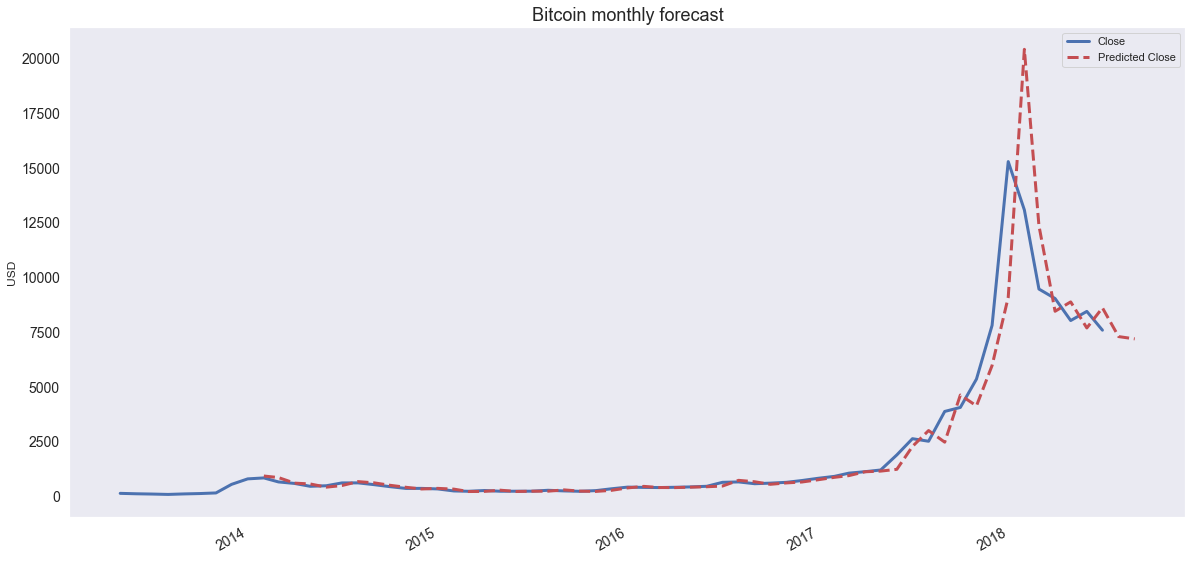

In [16]:
# Prediction
btc_month_pred = btc_month[['Close']]
date_list = [datetime(2018, 6, 30), datetime(2018, 7, 31), datetime(2018, 8, 31)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2014, 1, 31), end=datetime(2018, 8, 31)), lmbda)

btc_month_pred.Close.plot(linewidth=3)
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close', linewidth=3)
plt.legend()
plt.grid()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')


In [17]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    

In [18]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())


      parameters         aic
49  (2, 2, 0, 1) -198.715512
21  (1, 0, 1, 1) -198.416794
19  (1, 0, 0, 1) -198.166236
7   (0, 1, 0, 1) -197.591429
9   (0, 1, 1, 1) -197.415584
                                      SARIMAX Results                                      
Dep. Variable:                           close_box   No. Observations:                   63
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 4)   Log Likelihood                 105.358
Date:                             Sun, 31 Oct 2021   AIC                           -198.716
Time:                                     23:21:38   BIC                           -186.353
Sample:                                 04-30-2013   HQIC                          -193.900
                                      - 06-30-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

Dickey–Fuller test:: p=0.006378


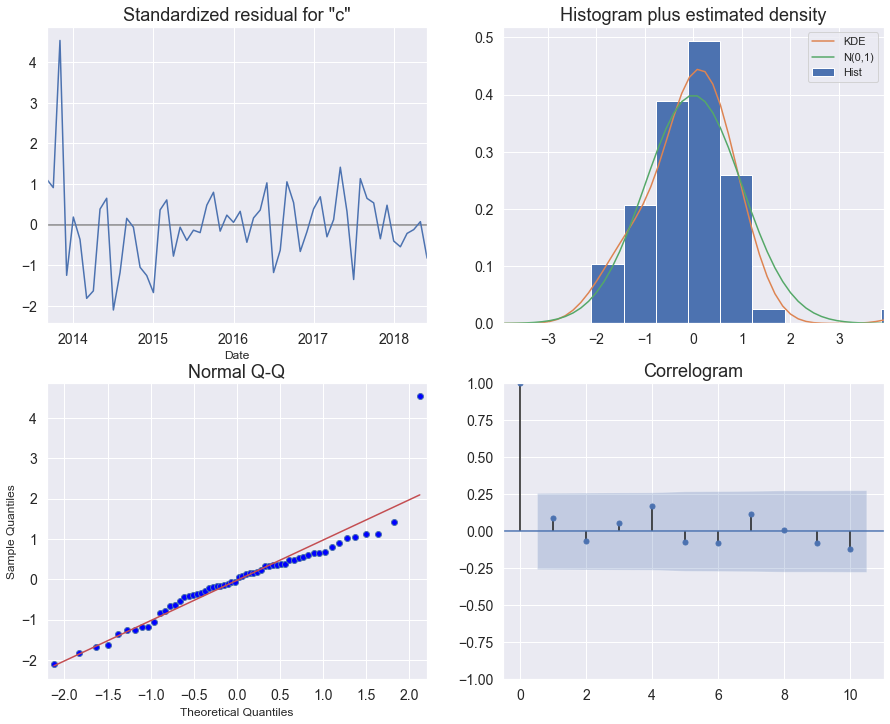

In [19]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()


Dickey–Fuller test:: p=0.006378


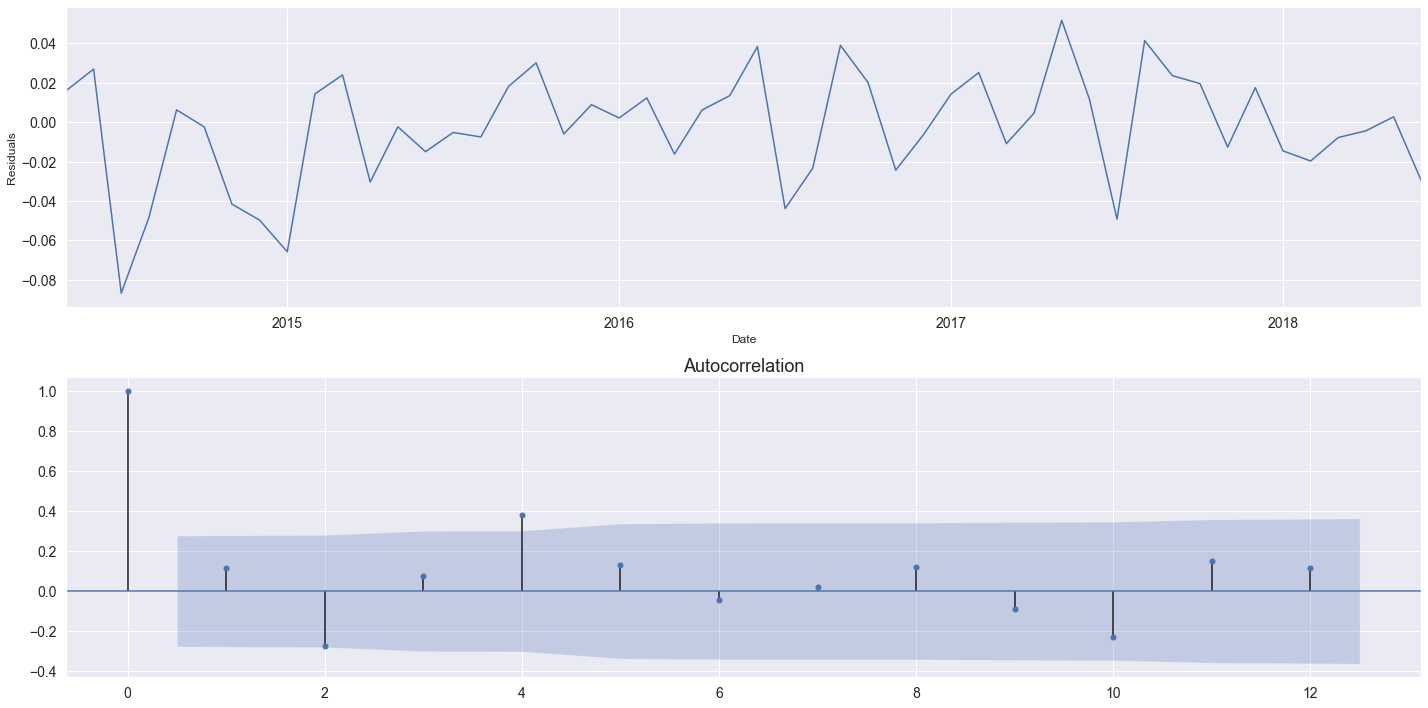

In [20]:
# STL-decomposition
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(best_model.resid[13:].values.squeeze(), lags=12, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

plt.tight_layout()


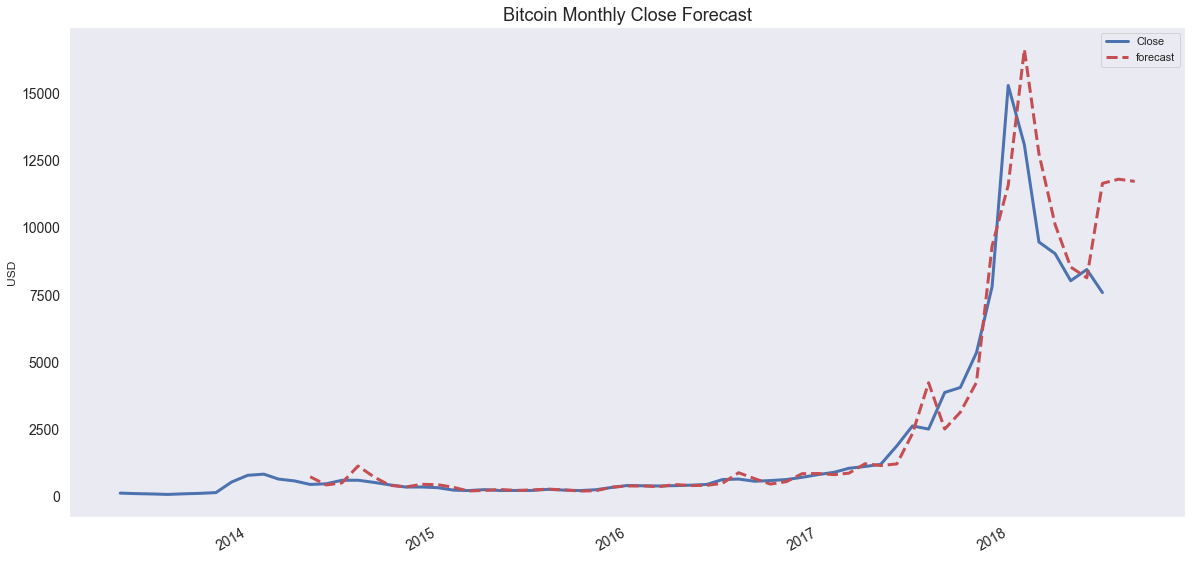

In [21]:
# Prediction
btc_month_sarima = btc_month[['Close']]
date_list = [datetime(2018, 6, 30), datetime(2018, 7, 31), datetime(2018, 8, 31)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_sarima = pd.concat([btc_month_sarima, future])

btc_month_sarima['forecast'] = invboxcox(best_model.predict(start=12, end=75), lmbda)

btc_month_sarima.Close.plot(linewidth=3)
btc_month_sarima.forecast.plot(color='r', ls='--', label='forecast', linewidth=3)
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.grid()
plt.savefig('bitcoin_monthly_forecast.png')


In [22]:
btc_month_predict = btc_month['2015-01-01':'2017-01-01']

# Get a naive forecast
close_history = [x for x in btc_month_predict['Close']]
predictions = list()
for i in range(len(btc_month_predict)):
    # predict
    predictions.append(close_history[-1])
    # update observation
    close_history.append(btc_month_predict.iloc[i]['Close'])
    
# Calculate RMSE
rmse = sqrt(mean_squared_error(btc_month_predict['Close'], predictions))
print('RMSE: %.2f' % rmse)


RMSE: 131.54


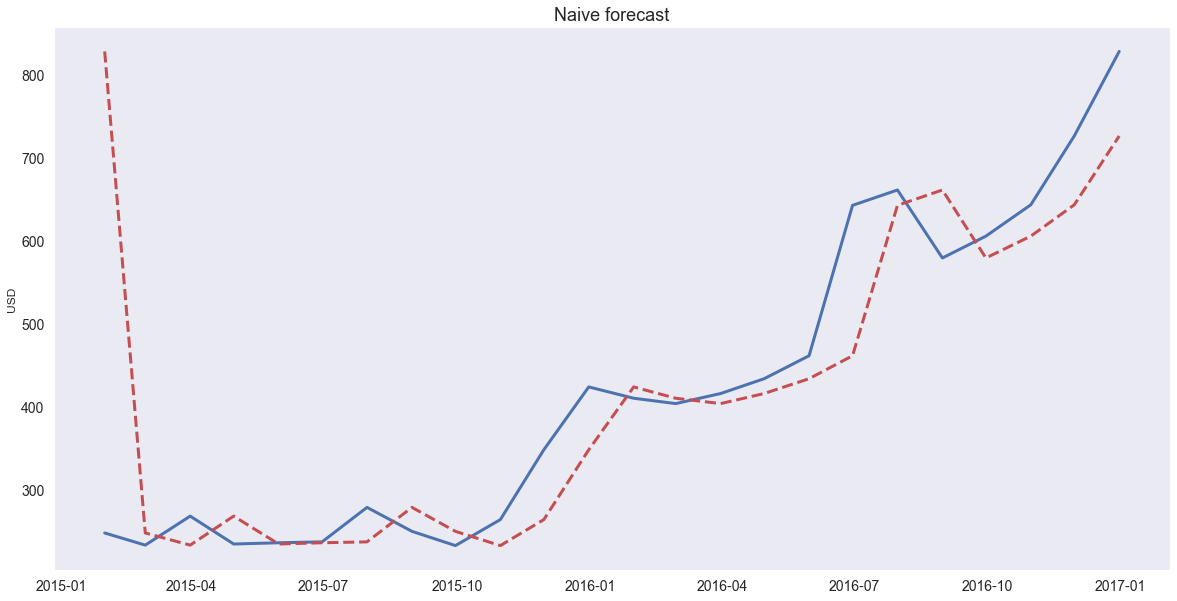

In [23]:
# Plot predictions vs actual
btc_month_predict['naive_forecast'] = predictions
plt.plot(btc_month_predict['Close'],  linewidth=3)
plt.plot(btc_month_predict['naive_forecast'], color='r', ls='--', label='forecast', linewidth=3)
plt.title('Naive forecast')
plt.ylabel('USD')
plt.grid()


In [24]:
y_forecasted = btc_month_sarima.forecast
y_truth = btc_month_sarima['2015-01-01':'2017-01-01'].Close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))


Mean Squared Error: 78.28


Text(0, 0.5, 'USD')

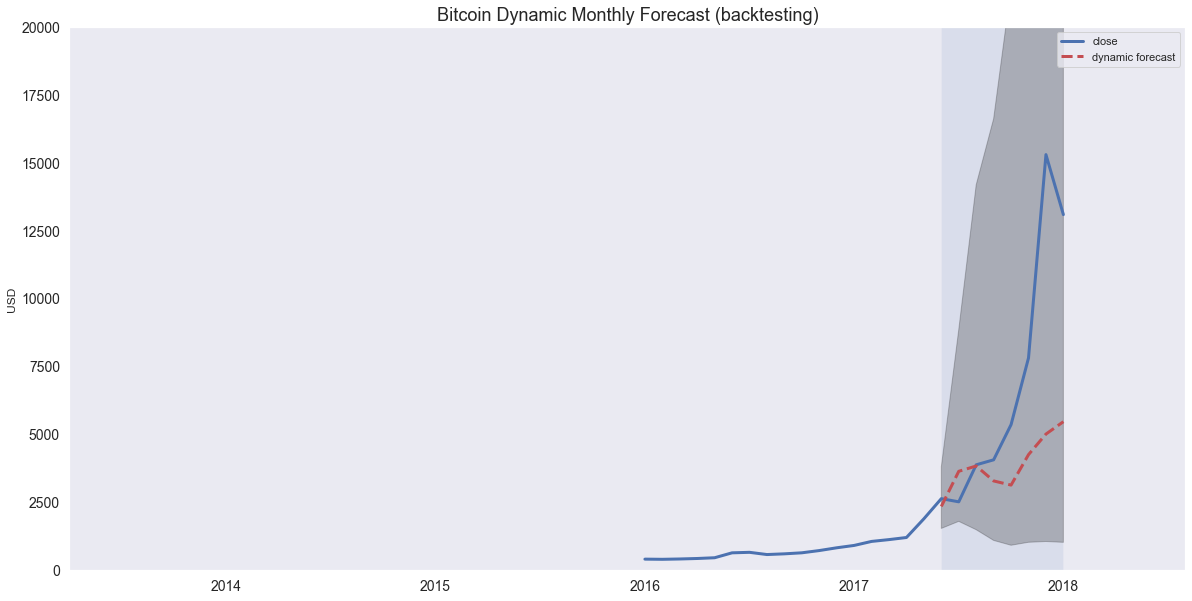

In [25]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2017-06-30')
t2 = pd.to_datetime('2018-01-31')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month_sarima['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
plt.ylim((0,20000))

btc_month_sarima.Close['2016':'2018-01'].plot(label='close', linewidth=3)
btc_month_sarima.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast', linewidth=3)

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.grid()
plt.ylabel('USD')


Text(0, 0.5, 'USD')

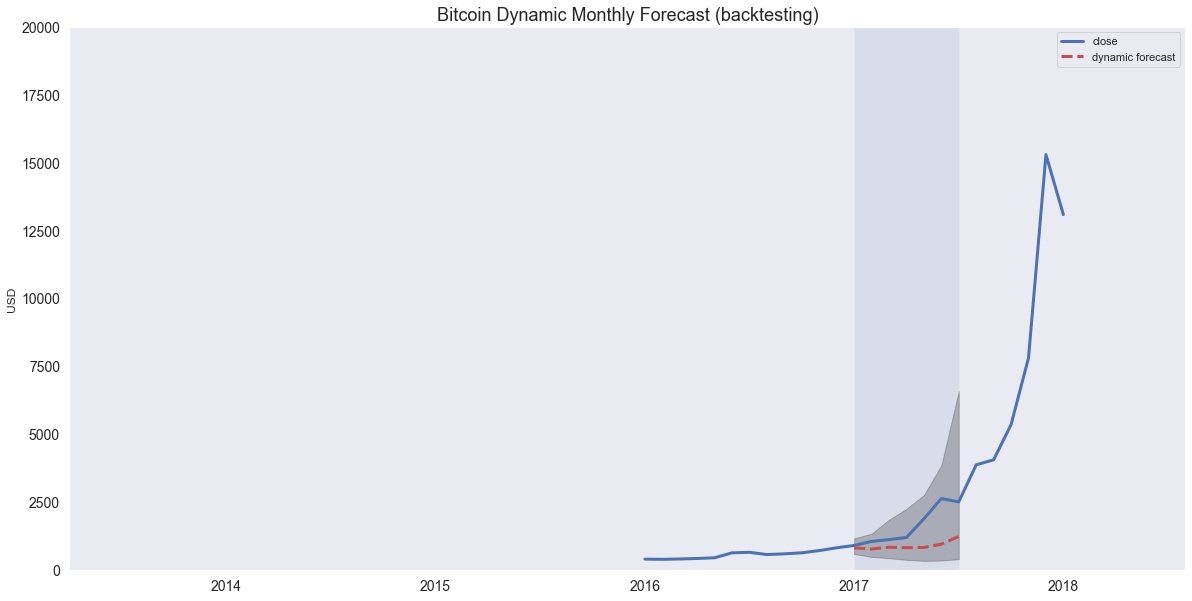

In [26]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2017-01-31')
t2 = pd.to_datetime('2017-07-31')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month_sarima['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
plt.ylim((0,20000))

btc_month_sarima.Close['2016':'2018-01'].plot(label='close', linewidth=3)
btc_month_sarima.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast', linewidth=3)

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.grid()
plt.ylabel('USD')


In [ ]:
# - Use a different technique to standardise the distribution
# - Use different differentiation techniques
# - Discard the time period before cryptocurrencies started taking off
# - Try modelling per day instead of month, with a smaller forecast window
# - Use other models or machine learning instead of ARIMA